In [1]:
import sys 
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# sys.path.append('/users/jiajiaz/.conda/envs/mybrainiak/lib/python3.6/site-packages')
sys.path.append('../Multivariate_analyses_Daphne/')
import os 
import h5py
import glob
import time
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn import input_data

from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nibabel.affines import apply_affine
import nibabel as nib
import time

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
from brainiak.searchlight.searchlight import Searchlight
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats
from numpy.linalg import inv

# import own functions
import utils
reload(utils)

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

# Load pre-processed data

In [2]:
BOLD_path = '/ncf/gershman/Lab/scripts/matlab/VGDL_fMRI/mat/'
path = './data/'
all_data = []
all_vol = []
all_df = []
all_tcf = []
all_tcfc = []
level_TRs = [-1]*54 # game i level j has index (i-1) * 9 + j-1
num_subj = 8

# mask_nii is the functional mask, this selects the brain voxels
mask_nii_NS = nib.load(os.path.join(path, 'mask_nosmooth.nii')) 
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 
print(mask_nii.shape)
# inverse of the affine matrix: mni2cor
inv_affine = inv(mask_nii_NS.affine) # get the transformation matrix

# load mask and get voxel coordinates
# mask_arr = np.load(path+'mask_arr.npy') 
filename = 'BOLD_subj1_nosmooth.mat'
data = h5py.File(BOLD_path+filename,'r')
mask_mat = data['mask'].value
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

level_TRs = np.load(path+'level_TRs.npy')
num_TR = sum(level_TRs)
print(num_TR)
vol4D = mask_nii.shape+(num_TR,)
coords = tuple(coords_mat)
num_voxel = len(np.where(mask_nii_NS.dataobj)[0])

(79, 95, 79)
1402


In [3]:
# Load the volume data 4D
all_vol = []
for subj in range(4):
    all_vol.append(np.load(path+'vol'+str(subj)+'.npy'))
for subj in range(4,num_subj):
    all_vol.append(np.load(path+'vol'+str(subj)+'.npy'))
all_tcfc = np.load(path+'all_tcfc.npy')
all_tcf = np.load(path+'all_tcf.npy')

In [74]:
all_tcfc

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401
0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
all_tcfc = pd.DataFrame(np.load(path+'all_tcfc.npy')).transpose()
num_fakes = 10
excluded_TRs = []
for game_id in range(6):
    begin = sum(level_TRs[:game_id*9])
    end = sum(level_TRs[:game_id*9+9])
    excluded_TRs += list(range(begin, begin+3)) + list(range(end-3,end))
all_tcfc.loc[excluded_TRs, :] = 0

all_real_and_fake = [all_tcfc]
for subj in range(num_subj):
    print(subj)
    freqs = all_tcfc.drop(subj, axis=1).eq(1).sum(axis = 1)/(num_subj-1)
    fake_tcfs = []
    for i in range(num_fakes):
        fake_tcf = pd.Series([0]*num_TR)
        for TR in range(num_TR):
            if TR not in excluded_TRs:
                fake_tcf[TR] = np.random.choice([0,1], p=[1-freqs.loc[TR],freqs.loc[TR]])
        fake_tcfs.append(fake_tcf)
    leave_out_tcf = pd.concat(fake_tcfs,axis=1)
    all_real_and_fake.append(leave_out_tcf)


0
1
2
3
4
5
6
7


# Translate from MNI Space

In [5]:
# theory ROIs (model-based), encoding theory
# all MNI coordinates!
R_IFG_Tri = [42, 28, 26]
L_Insula = [-30, 28, 2]
R_DMPFC = [6, 38, 40]
L_IFG_Tri = [-50, 44, 12]
L_MTG = [-64, -50, 4]
R_MTG = [58, -36, 8]

# Theory_change_flag ROIs, updating theory
R_IFG_Oper_U = [48, 12, 28]
L_PPC_U = [-56, -32, 46]
R_IFG_Tri_U = [52, 38, 16]
R_AG_U = [32, -60, 34]
L_Fusiform_U = [-40, -58, -12]
L_IFG_Oper_U = [-42, 4, 28]
R_PHC_U = [26, -42, -8]

# create dictionary to map points to roi names
roi_dict = {'right inferior frontal gyrus (Tri)':R_IFG_Tri, 'left_insula':L_Insula, 'right dorsalmedial PFC':R_DMPFC,
            'left inferior frontal gyrus (Tri)':L_IFG_Tri, 'left middle temporal gyrus':L_MTG, 'right middle temporal gyrus':R_MTG
           }

brain_mask = np.array(mask_nii.dataobj)
roi_mask = np.zeros(brain_mask.shape)
print(roi_mask[roi_mask==1].shape)
native_roi_coords = []
for mni_coords in roi_dict:
    native_coords = apply_affine(aff=inv_affine, pts=roi_dict[mni_coords]).astype(int) # from mni2cor
#     native_roi_coords += native_coords.astype(int)
    roi_mask[tuple(native_coords)] = 1
print(roi_mask[roi_mask==1].shape)

(0,)
(6,)


# Searchlight

# Prepare arguments and kernel

In [6]:
# Preset the variables
data = all_vol
mask = roi_mask
bcvar = all_real_and_fake # first element should be num_TRs*8, then should be num_subj * [num_TRs * num_fake]
sl_rad = 8
max_blk_edge = 5
pool_size = 1
# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print("Number of subjects: " + str(len(data)))
print("Input data shape: " + str(data[0].shape))
print("Input mask shape: " + str(mask.shape) + "\n")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute(data, mask)
# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. 
sl.broadcast(bcvar)

Setup searchlight inputs
Number of subjects: 8
Input data shape: (79, 95, 79, 1402)
Input mask shape: (79, 95, 79)



In [11]:
all_real_and_fake[2]

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1397,0,0,0,0,0,0,0,0,0,0
1398,0,0,0,0,0,0,0,0,0,0
1399,0,0,0,0,0,0,0,0,0,0
1400,0,0,0,0,0,0,0,0,0,0


In [33]:
# Set up the kernel
def avg_corr(data, sl_mask, myrad, bcvar):
    all_real_and_fake = bcvar
    num_subj= len(data)
    num_TR = all_real_and_fake[0].shape[0]
    
    all_mean_cd = []
    all_cd_num_flag_corr = []
    tcf_cd_real_all = []
    tcf_cd_fake_all = []
    num_flags_real_all = []
    num_flags_fake_all = []
    # Loop over subject: 
    for subj in range(num_subj):
        subj_mean_cd = []
        subj_cd_num_flag_corr = []
        data4D = data[subj]
        bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T
        
        # Below is for the subject tcfs
        tcf_cd_subj = []
        num_flags_subj = []
        subj_real = all_real_and_fake[0][subj]
        subj_real_ids = subj_real[subj_real > 0].index.values
        
        for flag_idx in subj_real_ids:
            before_idx = flag_idx - 3
            after_idx = flag_idx + 3
            flag_cd = 1 - np.corrcoef(bolddata_sl[before_idx], bolddata_sl[after_idx])[1,0]
            tcf_cd_subj.append(flag_cd)
            flag_num = np.sum(subj_real[before_idx:after_idx])
            num_flags_subj.append(flag_num)
        # For analysis 1
        subj_mean_cd.append(np.mean(tcf_cd_subj))
        tcf_cd_real_all += tcf_cd_subj
        # For analysis 2
        corr2 = np.corrcoef(tcf_cd_subj, num_flags_subj)[1,0]
        subj_cd_num_flag_corr.append(corr2)
        num_flags_real_all.append(corr2)
        
        # Below is for fake tcfs
        for idx in range(num_fakes):
            tcf_cd_subj = []
            num_flags_subj = []
            subj_fake = all_real_and_fake[subj+1][idx]
            subj_fake_ids = subj_fake[subj_fake > 0].index.values
            for flag_idx in subj_fake_ids:
                before_idx = flag_idx - 3
                after_idx = flag_idx + 3
                flag_cd = 1 - np.corrcoef(bolddata_sl[before_idx], bolddata_sl[after_idx])[1,0]
                tcf_cd_subj.append(flag_cd)
                flag_num = np.sum(subj_fake[before_idx:after_idx])
                num_flags_subj.append(flag_num)
            # For analysis 1
            subj_mean_cd.append(np.mean(tcf_cd_subj))
            tcf_cd_fake_all += tcf_cd_subj
            # For analysis 2
            corr2 = np.corrcoef(tcf_cd_subj, num_flags_subj)[1,0]
            subj_cd_num_flag_corr.append(corr2)
            num_flags_fake_all.append(corr2)
        all_mean_cd.append(stats.percentileofscore(subj_mean_cd[1:], subj_mean_cd[0]))
        all_cd_num_flag_corr.append(stats.percentileofscore(subj_cd_num_flag_corr[1:], subj_cd_num_flag_corr[0]))
    # Finally, get the all-around average real vs fake
    all_mean_cd.append(stats.percentileofscore(tcf_cd_fake_all, np.mean(tcf_cd_real_all)))
    all_cd_num_flag_corr.append(stats.percentileofscore(\
                                num_flags_fake_all, \
                                np.mean(num_flags_real_all)))
            
    return [all_mean_cd, all_cd_num_flag_corr]

## Execute Searchlight

In [34]:
# Execute searchlight on 8 subjects
print("Begin Searchlight\n")
sl_result_allsubj = sl.run_searchlight(avg_corr, pool_size=pool_size)
print("End Searchlight\n")

Begin Searchlight

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
End Searchlight



# Collect Searchlight Results

## Which ROIs encode theories changes?

In [35]:
# region
# the index of output
# subj
# sl_result_allsubj[mask==1][region][index_output][subj]
for region in range(len(roi_dict)):
    print("region",region)
    rg_data = sl_result_allsubj[mask==1][region]
    all_cd_perc = rg_data[0]
    print("    corr distance", all_cd_perc)
    all_slope_perc = rg_data[1]
    print("    slope:", all_slope_perc)

region 0
    corr distance [10.0, 80.0, 100.0, 10.0, 20.0, 100.0, 80.0, 60.0, 68.96673120929414]
    slope: [100.0, 50.0, 80.0, 70.0, 50.0, 60.0, 70.0, 80.0, 75.0]
region 1
    corr distance [20.0, 60.0, 90.0, 10.0, 0.0, 90.0, 70.0, 40.0, 73.77222320014081]
    slope: [100.0, 40.0, 50.0, 90.0, 60.0, 80.0, 100.0, 40.0, 85.0]
region 2
    corr distance [50.0, 30.0, 90.0, 20.0, 0.0, 100.0, 50.0, 90.0, 77.34553775743707]
    slope: [100.0, 10.0, 40.0, 90.0, 80.0, 70.0, 100.0, 90.0, 80.0]
region 3
    corr distance [10.0, 50.0, 100.0, 30.0, 0.0, 100.0, 70.0, 40.0, 73.45537757437071]
    slope: [90.0, 80.0, 30.0, 80.0, 90.0, 80.0, 80.0, 70.0, 73.75]
region 4
    corr distance [90.0, 80.0, 70.0, 30.0, 0.0, 100.0, 40.0, 70.0, 76.43020594965675]
    slope: [100.0, 60.0, 30.0, 90.0, 70.0, 70.0, 70.0, 60.0, 80.0]
region 5


TypeError: 'NoneType' object is not subscriptable

In [31]:

print(len(sl_result_allsubj[mask==1]), \
      len(sl_result_allsubj[mask==1][1]), \
      sl_result_allsubj[mask==1][1][1], \
#       len(sl_result_allsubj[mask==1][1][1][1]), \
#       sl_result_allsubj[mask==1][1][0][1]
     )

6 2 [100.0, 10.0, 50.0, 20.0, 20.0, 60.0, 80.0, 60.0, 53.75]


## Which regions have the following relationship: more tcfs corresponds to less corr

region 0
    Subj  0


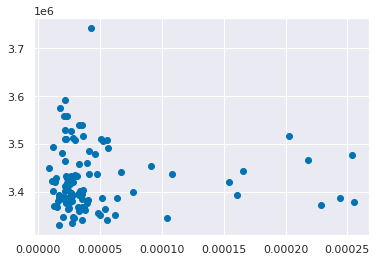

    Subj  1


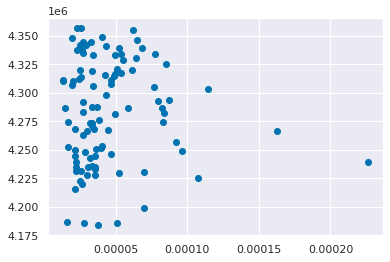

    Subj  2


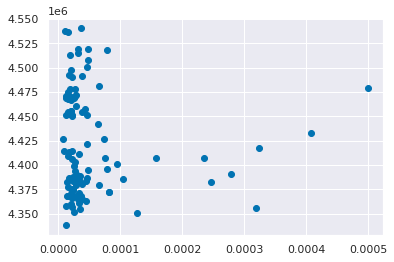

    Subj  3


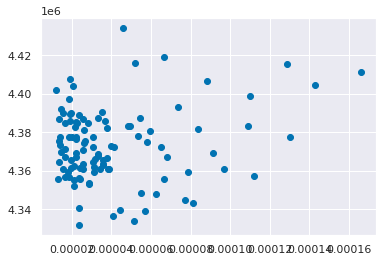

    Subj  4


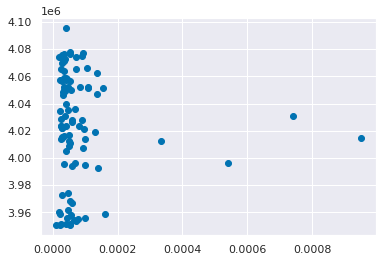

    Subj  5


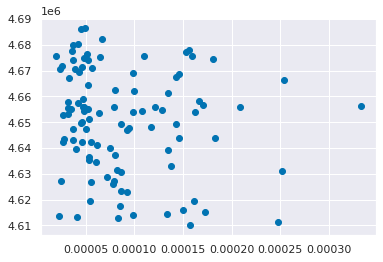

    Subj  6


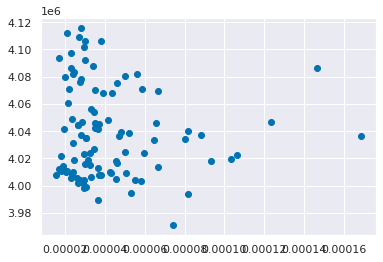

    Subj  7


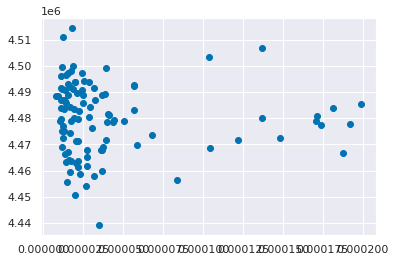

region 1
    Subj  0


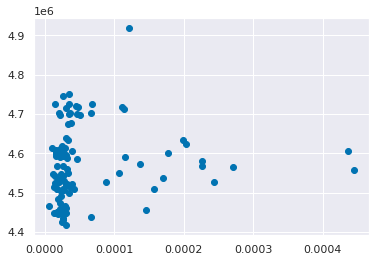

    Subj  1


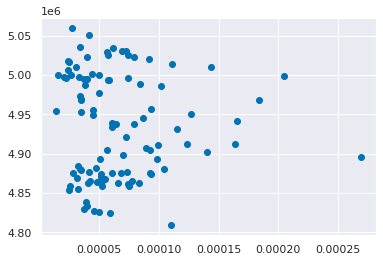

    Subj  2


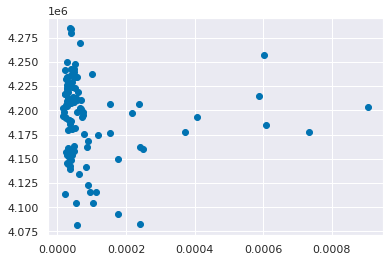

    Subj  3


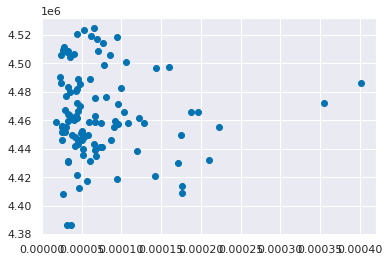

    Subj  4


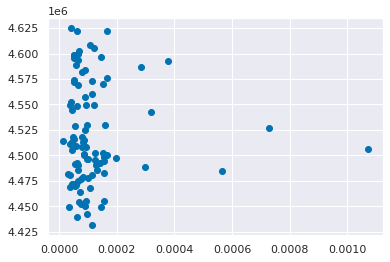

    Subj  5


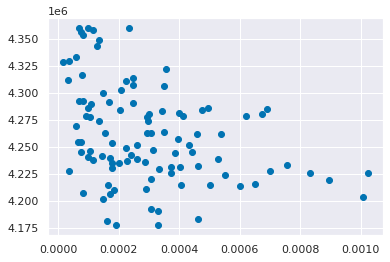

    Subj  6


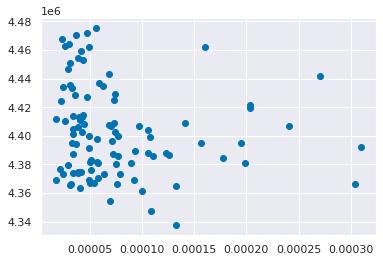

    Subj  7


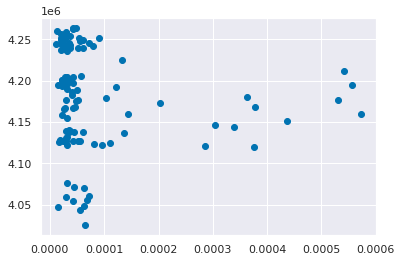

region 2
    Subj  0


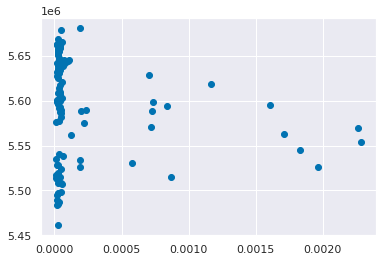

    Subj  1


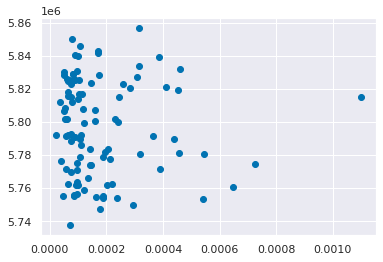

    Subj  2


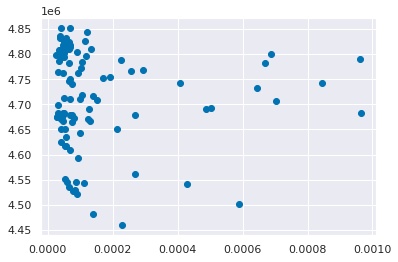

    Subj  3


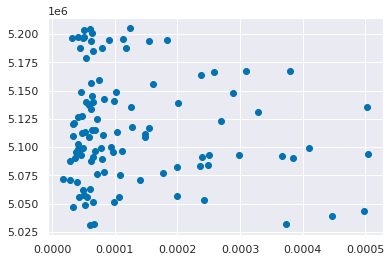

    Subj  4


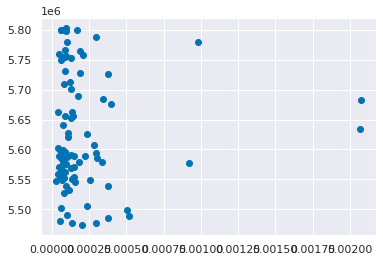

    Subj  5


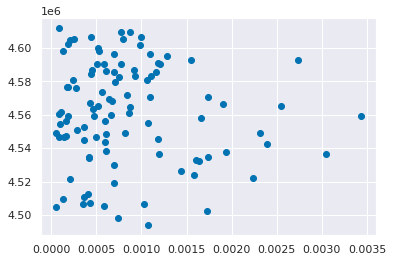

    Subj  6


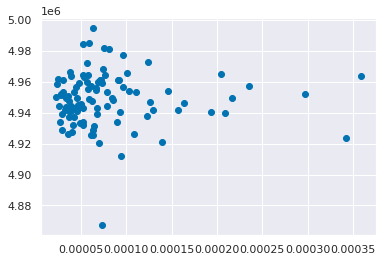

    Subj  7


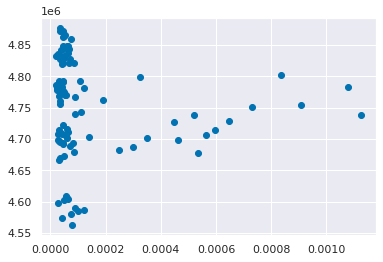

region 3
    Subj  0


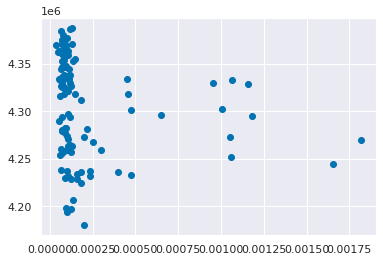

    Subj  1


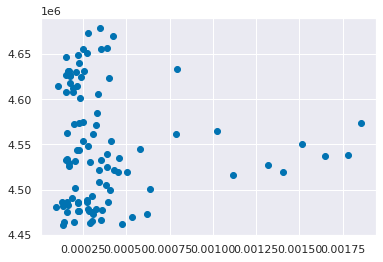

    Subj  2


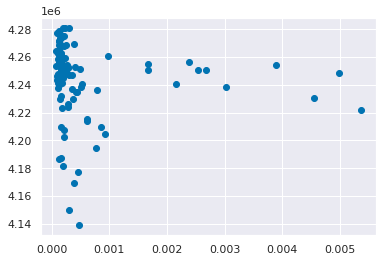

    Subj  3


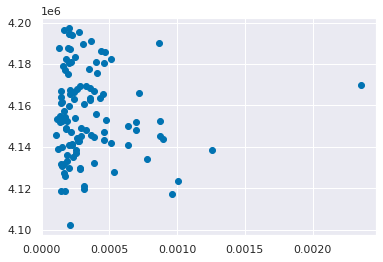

    Subj  4


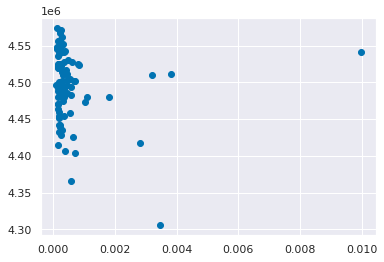

    Subj  5


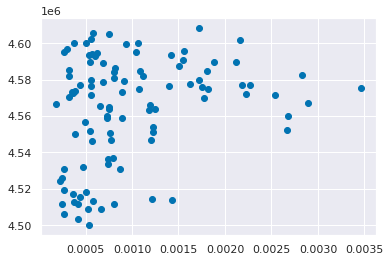

    Subj  6


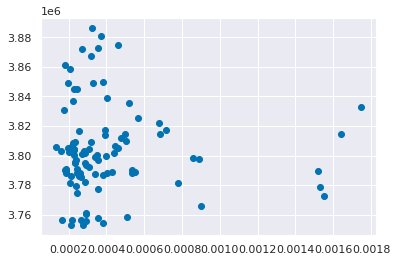

    Subj  7


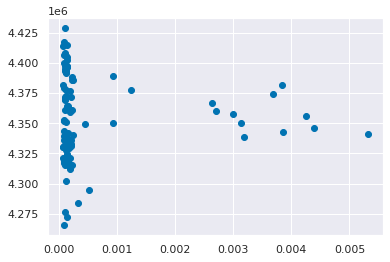

region 4
    Subj  0


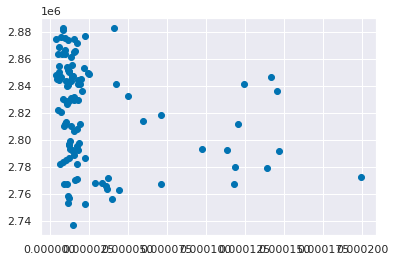

    Subj  1


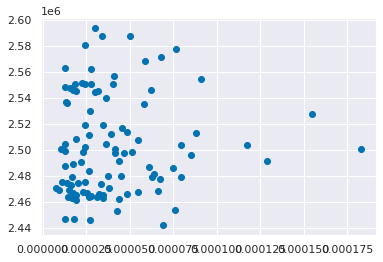

    Subj  2


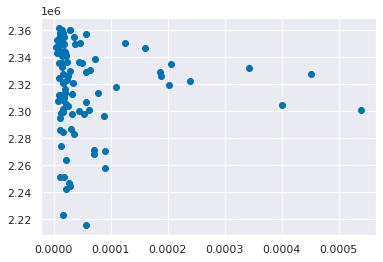

    Subj  3


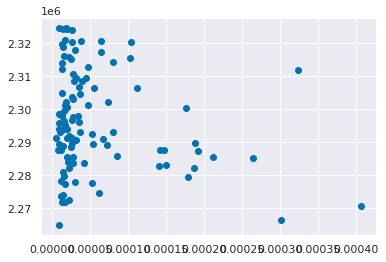

    Subj  4


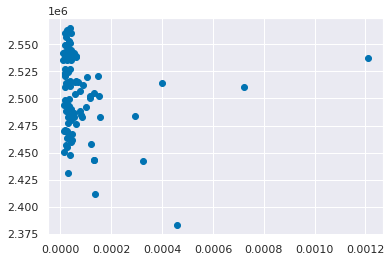

    Subj  5


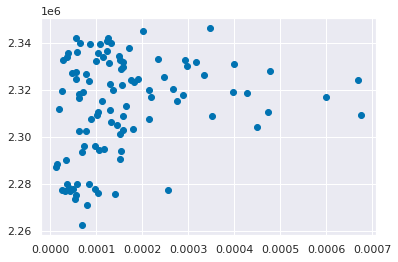

    Subj  6


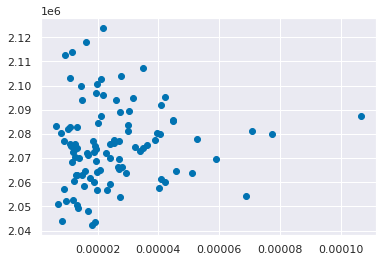

    Subj  7


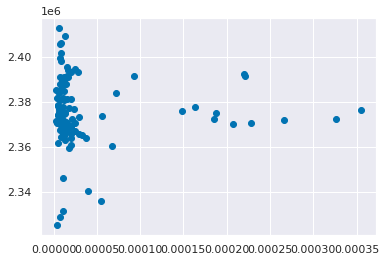

region 5
    Subj  0


TypeError: 'NoneType' object is not subscriptable

In [57]:
for region in range(len(roi_dict)):
    print("region",region)
    for subj in range(num_subj):
        print("    Subj ",subj)
        subj_real_rs = sl_result_allsubj[mask==1][region][1][subj]
        subj_tcfc = sl_result_allsubj[mask==1][region][2][subj]
        plt.scatter([1-i for i in subj_real_rs], subj_tcfc)
        plt.show()

region 0
    Subj  0
    Subj  1
    Subj  2
    Subj  3
    Subj  4
    Subj  5
    Subj  6
    Subj  7


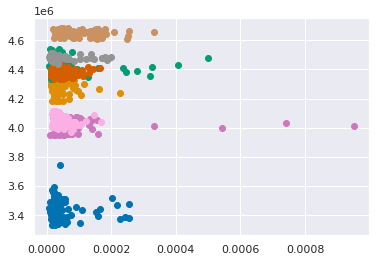

region 1
    Subj  0
    Subj  1
    Subj  2
    Subj  3
    Subj  4
    Subj  5
    Subj  6
    Subj  7


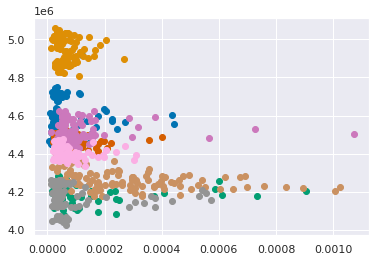

region 2
    Subj  0
    Subj  1
    Subj  2
    Subj  3
    Subj  4
    Subj  5
    Subj  6
    Subj  7


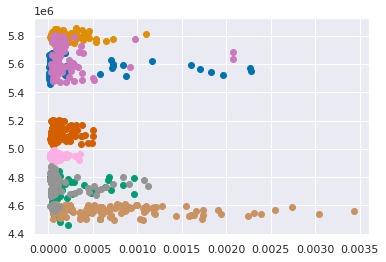

region 3
    Subj  0
    Subj  1
    Subj  2
    Subj  3
    Subj  4
    Subj  5
    Subj  6
    Subj  7


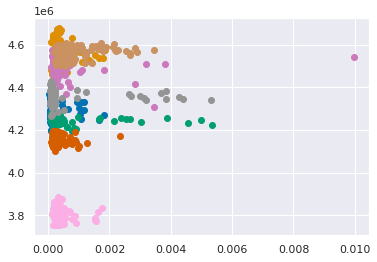

region 4
    Subj  0
    Subj  1
    Subj  2
    Subj  3
    Subj  4
    Subj  5
    Subj  6
    Subj  7


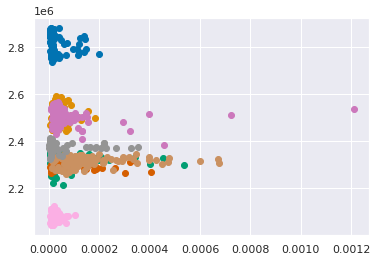

region 5
    Subj  0


TypeError: 'NoneType' object is not subscriptable

In [58]:
for region in range(len(roi_dict)):
    print("region",region)
    for subj in range(num_subj):
        print("    Subj ",subj)
        subj_real_rs = sl_result_allsubj[mask==1][region][1][subj]
        subj_tcfc = sl_result_allsubj[mask==1][region][2][subj]
        plt.scatter([1-i for i in subj_real_rs], subj_tcfc)
    plt.show()